In [27]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import pandas as pd
import warnings
import weblogo
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment 

warnings.filterwarnings('ignore')

# Exercise 1

In [3]:
def calculate_selection_probabilities(fitness_function):
    individuals = [2, 3, 4]
    fitness_values = [fitness_function(x) for x in individuals]
    total_fitness = sum(fitness_values)
    selection_probabilities = [value / total_fitness for value in fitness_values]
    return individuals, fitness_values, selection_probabilities

def plot_pie_chart(individuals, probabilities, equation):
    labels = [f'x = {individual}' for individual in individuals]
    plt.pie(probabilities, labels=labels, autopct="%1.1f%%")
    plt.title(f"Selection Probabilities: {equation}")
    plt.savefig(f"figs/fitness_function_{equation}.png")
    plt.show()


----- Fitness Function: $f(x) = |x|$ -----
Individuals: [2, 3, 4]
Fitness Values: [2, 3, 4]
Selection Probabilities: [0.2222222222222222, 0.3333333333333333, 0.4444444444444444]


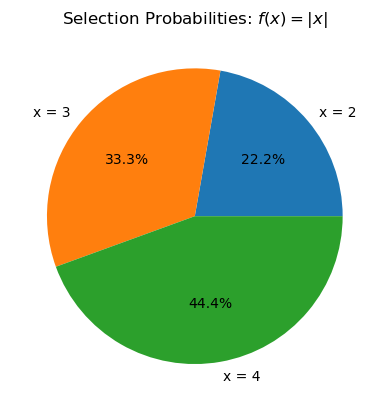


----- Fitness Function: $f(x) = x^2$ -----
Individuals: [2, 3, 4]
Fitness Values: [4, 9, 16]
Selection Probabilities: [0.13793103448275862, 0.3103448275862069, 0.5517241379310345]


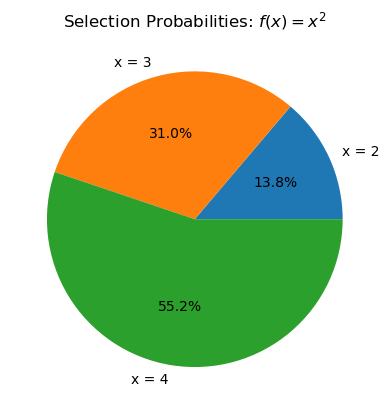


----- Fitness Function: $f(x) = 2x^2$ -----
Individuals: [2, 3, 4]
Fitness Values: [8, 18, 32]
Selection Probabilities: [0.13793103448275862, 0.3103448275862069, 0.5517241379310345]


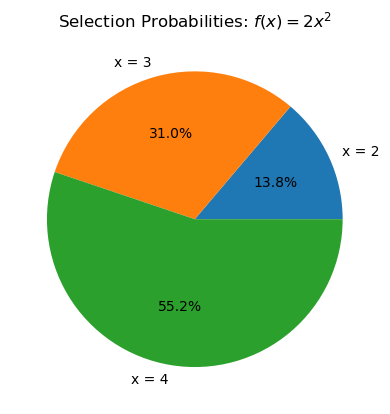


----- Fitness Function: $f(x) = x^2 + 20$ -----
Individuals: [2, 3, 4]
Fitness Values: [24, 29, 36]
Selection Probabilities: [0.2696629213483146, 0.3258426966292135, 0.4044943820224719]


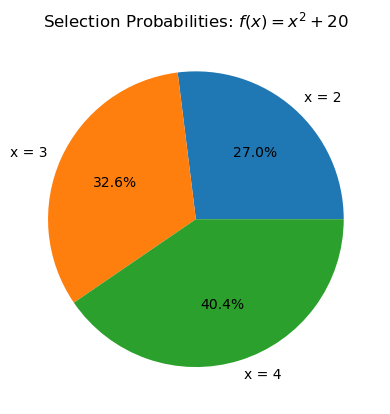

In [4]:
# define different fitness functions
fitness_functions = [
    (lambda x: abs(x), "$f(x) = |x|$"),
    (lambda x: x**2, "$f(x) = x^2$"),
    (lambda x: 2 * x**2, "$f(x) = 2x^2$"),
    (lambda x: x**2 + 20, "$f(x) = x^2 + 20$")
]

# calculate probabilities and plot for each function
for func, equation in fitness_functions:
    individuals, fitness_values, probabilities = calculate_selection_probabilities(func)
    print(f"\n----- Fitness Function: {equation} -----")
    print("Individuals:", individuals)
    print("Fitness Values:", fitness_values)
    print("Selection Probabilities:", probabilities)
    plot_pie_chart(individuals, probabilities, equation)

# Exercise 2

# Exercise 3

In [20]:
#HELPER FUNCTIONS FOR GENETIC ALGORITHM
def generate_random_string(length, alphabet):
  """Generates a random string of the given length from the alphabet."""
  return ''.join(random.choice(alphabet) for _ in range(length))

def fitness(target_string, string):
  """Calculates the fitness of a string based on fraction of 'correct' characters."""
  score = 0
  for i in range(len(target_string)):
    if target_string[i] == string[i]:
      score += 1
  return score / len(target_string)

def tournament_selection(target_string, population, N, k):
  """Selects N individuals from the population using tournament selection over k competitors per round."""
  selected = []
  for _ in range(N):
    competitors = random.sample(population, k)
    best = max(competitors, key=lambda x: fitness(target_string, x))
    selected.append(best)
  return selected

def crossover(parent1, parent2, crossover_rate):
  """Performs single-point crossover on two parent strings with probability equal to crossover_rate."""
  if random.random() < crossover_rate:
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
  else:
    child1, child2 = parent1, parent2
  return child1, child2

def mutate(string, mutation_rate, alphabet):
  """Mutates a string with a given probability."""
  mutated_string = list(string)
  for i in range(len(mutated_string)):
    if random.random() < mutation_rate:
      mutated_string[i] = random.choice(alphabet)
  return ''.join(mutated_string)

def pairwise_hamming_distance(population):
    """Calculates the mean pairwise Hamming distance in the population."""
    distances = [sum(a != b for a, b in zip(x, y)) for x in population for y in population]
    return np.mean(distances) / len(population[0])

def plot_population_diversity(diversity_data, experiment_name, mu_val):
    # Select 10 random diversity data curves
    random_indices = np.random.choice(len(diversity_data), size=10, replace=False)
    selected_data = [diversity_data[i] for i in random_indices]
    
    # preprocess the data to fit in the same plot
    max_length = max(len(data) for data in selected_data)
    x = np.arange(0, max_length * 10, 10)  # Adjusted for 10-generation intervals

    # extend the data to the max length
    for i, data in enumerate(selected_data):
        selected_data[i] = np.pad(data, (0, max_length - len(data)), 'constant', constant_values=np.nan)

    # Plot each curve with a different color and label
    plt.figure(figsize=(5, 4))
    for i, data in enumerate(selected_data):
        plt.plot(x, data, marker='o', label=f"Run {i+1}")  

    plt.xlabel('Generation')
    plt.ylabel('Mean Pairwise Hamming Distance')
    plt.ylim(0, 1) 
    plt.xlim(0, 100)
    plt.title(f'Population Diversity Over Generations for $\mu = {mu_val}$ from 10 Random Experiments')
    plt.savefig(f'figs/population_diversity_{experiment_name}.png')
    plt.show()


In [21]:
def genetic_algorithm(target_string, alphabet, population_size, generation_limit, crossover_rate, mutation_rate, k, USE_LIMIT=True):

  # generate initial population of random strings
  population = [generate_random_string(len(target_string), alphabet) for _ in range(population_size)]

  # ensure generational replacement by perforing N/2 crossovers each generation giving N children
  N_crossover = population_size // 2

  # initialize convergence variables
  generation_count = 0                                                     
  diversity_data = []                                                         
  diversity_interval = 10
  best_individual = max(population, key=lambda x: fitness(target_string, x))

  # run the genetic algorithm for a fixed number of generations
  while fitness(target_string, best_individual) != 1:
    # tournament select N individuals from the population
    selected = tournament_selection(target_string, population, N_crossover, k)

    # the winners can have babies with probability c
    children = []
    for i in range(0, len(selected), 2):
      child1, child2 = crossover(selected[i], selected[(i + 1) % len(selected)], crossover_rate)
      children.extend([child1, child2])

    # MUTATE babies with probability mu
    mutated_children = [mutate(child, mutation_rate, alphabet) for child in children]

    # kick out ALL the boomers (generational replacement without elitism)
    population = mutated_children

    # update convergence variables
    best_individual = max(population, key=lambda x: fitness(target_string, x))
    generation_count += 1

    # calculate diversity every 'diversity_interval' generations             
    if generation_count % diversity_interval == 0 or generation_count == 1:
        diversity = pairwise_hamming_distance(population)
        diversity_data.append(diversity)

    # stop if we reach the generation limit and USE_LIMIT is True
    if USE_LIMIT and generation_count >= generation_limit:
      last_generation_population = population #return the last population for weblogo
      break
  
  #return the last population for weblogo
  last_generation_population = population
  return best_individual, generation_count, diversity_data, last_generation_population

In [22]:
#set parameters consistent across experiments
target_string = "meoWmeOwmeoWOW" #target string of approximately 15 characters
alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ" #alphabet containing all lowercase and uppercase letters

L = len(target_string)
population_size = 200
crossover_rate = 1

### Run the experiments

Mutation Rate: 0.07142857142857142,  Success Rate: 1.00, Average Generation count: 88.74
Mutation Rate: 1e-14,  Success Rate: 0.02, Average Generation count: 98.43
Mutation Rate: 0.21428571428571427,  Success Rate: 0.00, Average Generation count: 100.00


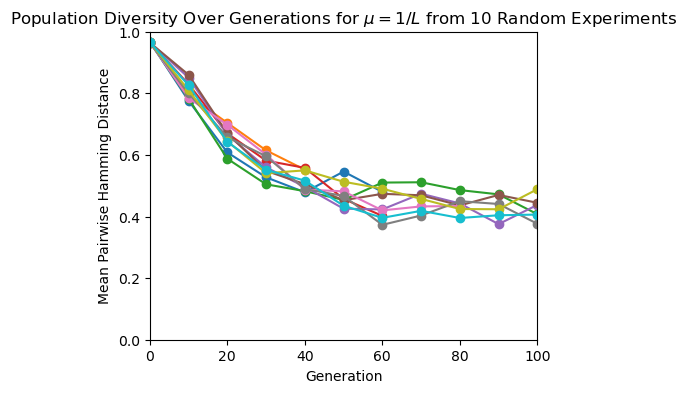

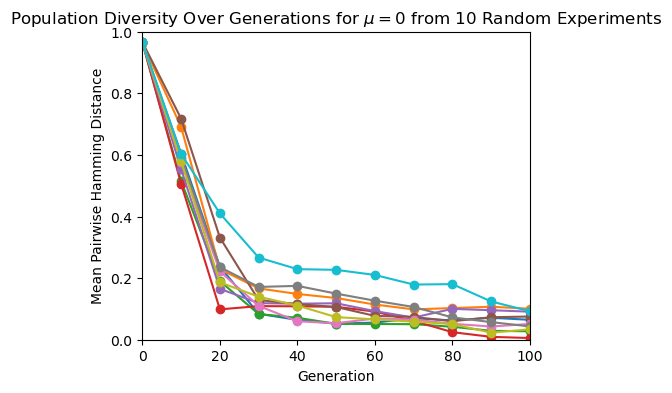

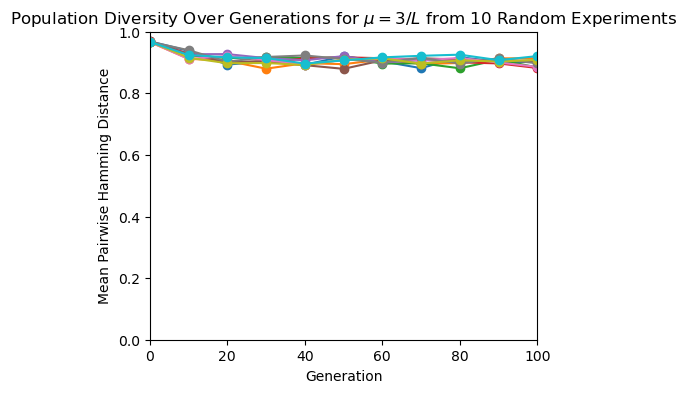

In [26]:
def run_genetic_algorithm(mutation_rate, USE_LIMIT):
    solutions, generation_counts, all_diversity_data, all_last_generations = [], [], [], []
    for _ in range(repeats):
        solution, generation_count, diversity_data, last_generation_population = genetic_algorithm(target_string, alphabet, population_size, generation_limit, crossover_rate, mutation_rate, k, USE_LIMIT)
        solutions.append(solution)
        generation_counts.append(generation_count)
        all_diversity_data.append(diversity_data) 
        all_last_generations.append(last_generation_population)

    successes = sum(solution == target_string for solution in solutions)
    success_rate = successes / repeats

    return success_rate, generation_counts, all_diversity_data, all_last_generations

# Set common parameters
k = 2   # number of competitors for each tournament selection
repeats = 100 # number of times to repeat each experiment
generation_limit = 100

# Run genetic algorithm with different mutation rates and generation limits
mutation_rate_1 = 1 / L
USE_LIMIT_1 = True

mutation_rate_2 = 1e-14 #avoid numerical issues
USE_LIMIT_2 = True

mutation_rate_3 = 3 / L
USE_LIMIT_3 = True

# Run results
success_rate_1, generation_counts_1, diversity_data_1, all_last_generations_1 = run_genetic_algorithm(mutation_rate_1, USE_LIMIT_1)
success_rate_2, generation_counts_2, diversity_data_2, all_last_generations_2 = run_genetic_algorithm(mutation_rate_2, USE_LIMIT_2)
success_rate_3, generation_counts_3, diversity_data_3, all_last_generations_3 = run_genetic_algorithm(mutation_rate_3, USE_LIMIT_3)

# Print results
print(f"Mutation Rate: {mutation_rate_1},  Success Rate: {success_rate_1:.2f}, Average Generation count: {np.mean(generation_counts_1):.2f}")
print(f"Mutation Rate: {mutation_rate_2},  Success Rate: {success_rate_2:.2f}, Average Generation count: {np.mean(generation_counts_2):.2f}")
print(f"Mutation Rate: {mutation_rate_3},  Success Rate: {success_rate_3:.2f}, Average Generation count: {np.mean(generation_counts_3):.2f}")

# Plot diversity over 10 random selected repeats 
plot_population_diversity(diversity_data_1, 1, mu_val = '1/L')
plot_population_diversity(diversity_data_2, 2, mu_val = '0')
plot_population_diversity(diversity_data_3, 3, mu_val = '3/L')

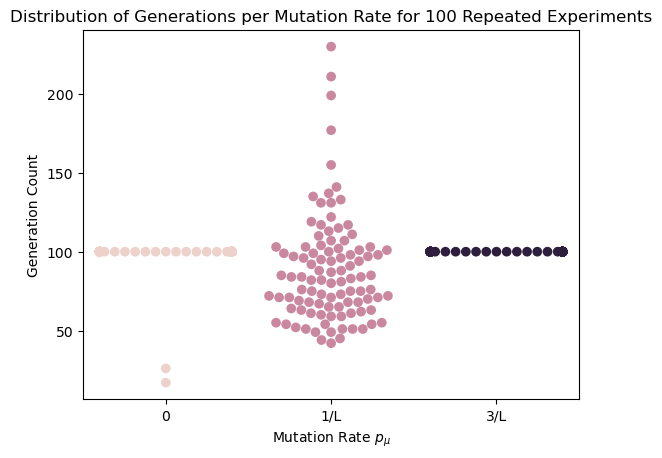

In [28]:
mutation_rates = [mutation_rate_1, mutation_rate_2, mutation_rate_3]
mutation_rates = [round(rate, 3) for rate in mutation_rates] # Round to 3 decimal places
generation_counts = [generation_counts_1, generation_counts_2, generation_counts_3]

# Create pandas DataFrame to use seaborn
data = {
    'mutation_rate': sum([[rate] * len(counts) for rate, counts in zip(mutation_rates, generation_counts)], []),
    'generation_count': sum(generation_counts, [])
}
df = pd.DataFrame(data)

#seaborn swarmplot
sns.swarmplot(
    x="mutation_rate",
    y="generation_count",
    hue="mutation_rate",  
    size=7,  
    data=df
)

# PLOT !
plt.xlabel("Mutation Rate $p_\mu$") 
plt.ylabel("Generation Count")  
plt.title(f"Distribution of Generations per Mutation Rate for {repeats} Repeated Experiments")
plt.legend().remove()  
x_ticks = ['0', '1/L', '3/L']
plt.xticks(range(len(mutation_rates)), x_ticks)  

plt.savefig('figs/mutation_rate_vs_generation_count.png')  
plt.show()

### Bonus: Plot over mu values

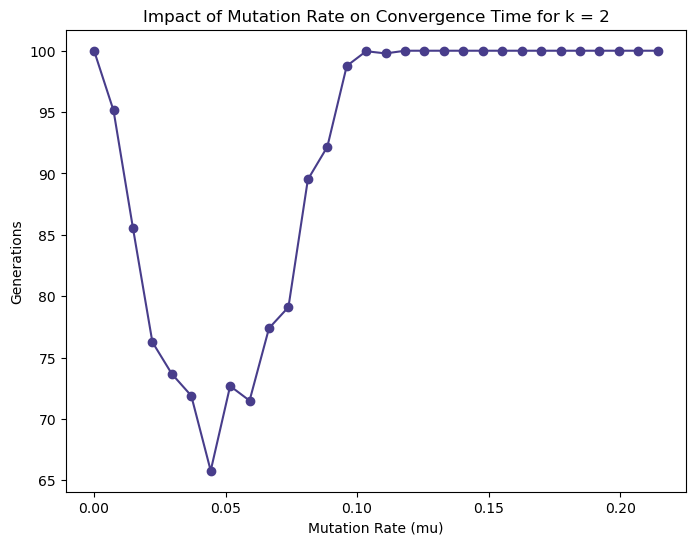

In [47]:
def run_experiment(mu_values,k):
    mean_genereation_counts = []
    for mu in mu_values:
        generation_counts = []
        for _ in range(repeats):
            _, generation_count, _,_ = genetic_algorithm(target_string, alphabet, population_size, generation_limit, crossover_rate, mutation_rate = mu, k = k, USE_LIMIT = True)
            generation_counts.append(generation_count)
        mean_genereation_counts.append(np.mean(generation_counts))
    return mean_genereation_counts

# Run the experiment
k = 2
mu_values = np.linspace(0, 3/L, 30)
mean_genereation_counts = run_experiment(mu_values,k)

# Plot the relationship between μ and t_{finish}
plt.figure(figsize=(8, 6))
plt.plot(mu_values, mean_genereation_counts, marker = 'o', color = 'DarkSlateBlue')
plt.xlabel("Mutation Rate (mu)")
plt.ylabel(f"Generations")
plt.title(f"Impact of Mutation Rate on Convergence Time for k = {k}")
plt.savefig('figs/mutation_rate_vs_convergence_time_k2.png')
plt.show()

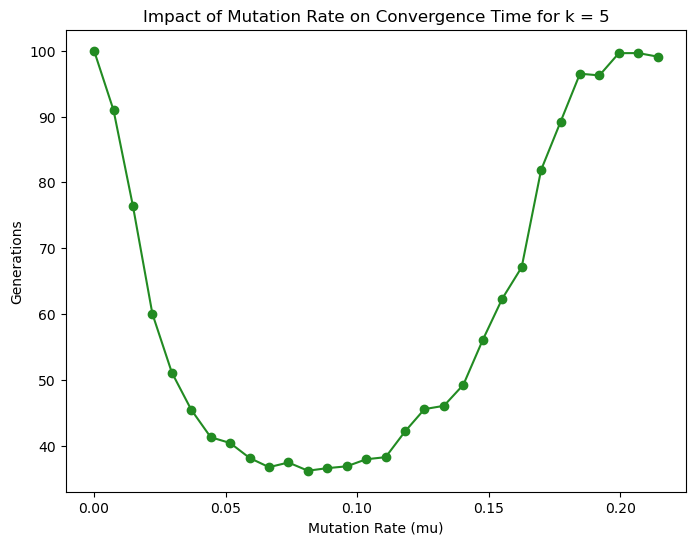

In [48]:
k = 5 #increase the number of competitors for each tournament selection

# Run the experiment
mu_values = np.linspace(0, 3/L, 30)
mean_genereation_counts = run_experiment(mu_values,k)

# Plot the relationship between μ and t_{finish}
plt.figure(figsize=(8, 6))
plt.plot(mu_values, mean_genereation_counts, marker = 'o', color = 'ForestGreen')
plt.xlabel("Mutation Rate (mu)")
plt.ylabel(f"Generations")
plt.title(f"Impact of Mutation Rate on Convergence Time for k = {k}")
plt.savefig('figs/mutation_rate_vs_convergence_time_k5.png')
plt.show()

# Exercise 4